0         879.60
1         906.70
2         902.60
3         866.70
4         821.90
5         869.80
6         853.70
7         893.90
8        1063.90
9        1099.70
10       1144.80
11       1144.20
12       1061.40
13       1082.40
14       1103.20
15       1099.10
16       1105.60
17       1100.70
18       1043.80
19       1016.00
20        975.60
21        979.70
22        982.60
23        933.40
DS          9.90
SR         10.07
TM_6       -1.00
TM_9       -2.00
TM_12      -4.00
TM_15      -5.00
TM_18      -6.00
WS_6        6.10
WS_9        3.30
WS_12       2.70
WS_15       2.10
WS_18       2.80
SK_6        4.00
SK_9        4.00
SK_12       4.00
SK_15       4.00
SK_18       4.00
PP_6       30.00
PP_9       30.00
PP_12      30.00
PP_15      30.00
PP_18      30.00
PR_9        0.00
PR_15       0.00
PR_21       0.00
Name: 210104, dtype: float64
0        535.179264
1        563.711494
2        561.230283
3        527.148832
4        484.231367
5        534.118838
6        520.50323

c:\Users\user\anaconda3\envs\yekim\lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 8 is too high: all coefficients will experience boundary effects.
  warnings.warn(


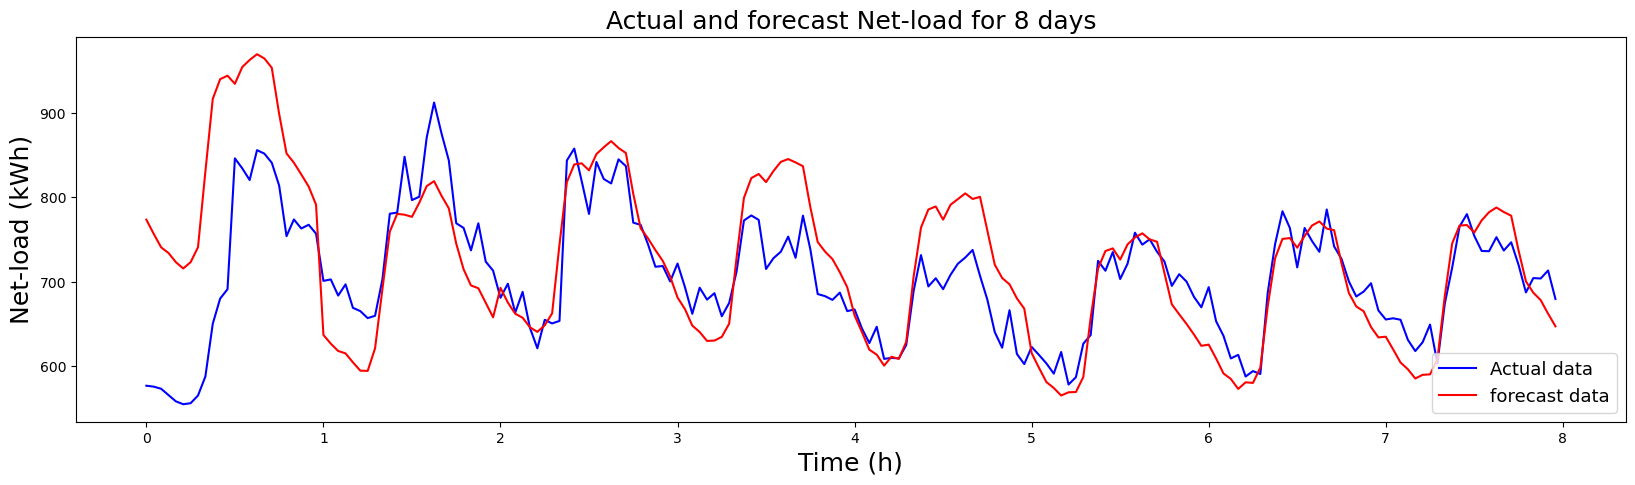

In [9]:
# DIRECT Net-load Forecasting Model


# ex.
# python netload_forecasting_model.py 1 RISE
# python netload_forecasting_model.py 1 DORM



import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
from torchmetrics import MeanAbsolutePercentageError as MAPE
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import datetime, sys, os
from torch.utils.data import Dataset
import pywt



class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

        
    def __getitem__(self, index):
        X = self.X[index]
        Y = self.Y[index]
        return (X, Y)
    
    def __len__(self):
        return len(self.X)



# USE_CUDA = torch.cuda.is_available()
# DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
DEVICE = 'cpu'
RANDOM_SEED = 2023
EPOCHS = 50000
LEARNING_RATE = 0.000001
BATCH_SIZE = 16
# BATCH_SIZE = int(sys.argv[2])

# patience 3, batch_size 16, learning rate 0.000001, model(50-64-256-64-24) shows the best result



class Net(nn.Module):
    def __init__(self, col_len, **model_config):
        super(Net, self).__init__()
        self.model_type = model_config['case']
        if model_config['case'] == 1:
            self.hidden_dim1 = int(col_len*10)
            self.hidden_dim2 = int(col_len*10*0.15)  #good
            
        self.fc1 = nn.Linear(col_len, self.hidden_dim1)
        self.fc2 = nn.Linear(self.hidden_dim1, self.hidden_dim2)
        self.fc3 = nn.Linear(self.hidden_dim2, 24)
        self.relu = nn.ReLU()

    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        output = self.fc3(x)
        return output



# Set seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)


# load the data and split into X and Y
def load_data(building):
    X = pd.read_csv(f'./processed_data/netload/X_netload_231days_{building}_49features.csv', index_col=0)
    Y = pd.read_csv(f'./processed_data/netload/Y_netload_231days_{building}.csv', index_col=0)
    label_interval = get_label_interval(X)
    # X = X.iloc[:,0:24]
    col = X.columns
    col_len = len(col)
    print(X.iloc[0])
    
    # apply wavelet transform to X
    for i in range(X.shape[0]):
        coeffs = pywt.wavedec(X.iloc[i,:], 'db4', level=8)
        for j in [1,2]:
            coeffs[j] = np.zeros_like(coeffs[j])
        X_wav = pywt.waverec(coeffs, 'db4')
        X.iloc[i,:] = X_wav[:49]

    print(X.iloc[0])
    X = torch.FloatTensor(X.values)
    Y = torch.FloatTensor(Y.values)
    return X, Y, col, col_len, label_interval


# split data into mini_train, valid, train, test
def split_data(X, Y, batch_size, data_len, train_pie, mini_train_pie):
    train_size = int(data_len * train_pie)
    mini_train_size = int(train_size * mini_train_pie)
    
    train_data = CustomDataset(X[:train_size], Y[:train_size])
    test_data = CustomDataset(X[train_size:], Y[train_size:])
    mini_train_data = CustomDataset(X[:mini_train_size], Y[:mini_train_size])
    valid_data = CustomDataset(X[mini_train_size:train_size], Y[mini_train_size:train_size])
    mini_train_dataloader = DataLoader(mini_train_data, batch_size = batch_size, shuffle = True)
    valid_dataloader = DataLoader(valid_data, batch_size = len(valid_data), shuffle = False)
    train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
    test_dataloader = DataLoader(test_data, batch_size = len(test_data), shuffle = False)
    
    return mini_train_dataloader, valid_dataloader, train_dataloader, test_dataloader, mini_train_size, train_size


# get the number of days of each month as label_interval list
def get_label_interval(X):
    label_interval = []
    for i in range(1, 13):
        cnt = 0
        for idx in X.index:
            if '21{0:0>2}'.format(i) in str(idx):
                cnt+=1
        label_interval.append(cnt)
    return label_interval
        
        

# create folder if not exist
def create_folder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)


# plot daily feature graphs
def plot_daily_feature(X, label_interval, col_list, fig_size, font_size, mini_train_point, valid_point, pre_save_path):
    unit=''
    netload_col_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']
    for idx, col in enumerate(col_list):
        if col in netload_col_list:
            if col == '0':
                data = torch.sum(X[:,idx:idx+24], axis=1).detach().numpy().reshape(-1)
                col = 'Net-load'
                unit = 'kWh'
            else:
                continue
        else:
            break

        # Create figure and plot the data
        fig = plt.figure(figsize=fig_size)
        ax = plt.axes()
        ax.plot(data)

        plt.title(col+" Fluctuation in 2021", fontsize = font_size)
        plt.xlabel('Month', fontsize = font_size)
        plt.ylabel(col+' ('+unit+')', fontsize = font_size)

        # Set the x-tick positions and labels
        x_ticks = []
        x_labels = []
        for i, interval in enumerate(label_interval):
            start = sum(label_interval[:i])
            x_ticks.append(start)
            x_labels.append(f'{i+1}')

        plt.axvline(x = mini_train_point, c='r')
        plt.axvline(x = valid_point, c='r')
        ax.set_xticks(x_ticks)
        ax.set_xticklabels(x_labels)
        
        # save the figure
        plt.savefig(pre_save_path+col+'.png')


def plot_loss(mini_train_loss_arr, val_loss_arr, range_start, best_val_epoch, fig_size, title, font_size, save_path):
    fig = plt.figure(figsize=fig_size)
    
    plt.subplot(221)
    plt.title(title, fontsize = font_size)
    # plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(mini_train_loss_arr, c = 'blue', label = 'Train')
    plt.plot(val_loss_arr, c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(222)
    plt.title(title+' from Epoch '+str(range_start)+' every epoch 200', fontsize = font_size)
    # plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(np.arange(range_start, best_val_epoch, 200), mini_train_loss_arr[range_start:best_val_epoch:200], c = 'blue', label = 'Train')
    plt.plot(np.arange(range_start, best_val_epoch, 200), val_loss_arr[range_start:best_val_epoch:200], c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(223)
    plt.title(title+' from Epoch '+str(range_start), fontsize = font_size)
    plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(mini_train_loss_arr[range_start:], c = 'blue', label = 'Train')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplot(224)
    plt.title(title+' from Epoch '+str(range_start), fontsize = font_size)
    plt.xlabel('Epoch', fontsize = font_size)
    plt.ylabel('Loss(MSE)', fontsize = font_size)
    plt.plot(val_loss_arr[range_start:], c = 'orange', label = 'Validation')
    plt.legend(loc='upper right', fontsize = font_size)

    plt.subplots_adjust(left=0.125, bottom=0.1,  right=0.9, top=0.9, wspace=0.35, hspace=0.35)
    
    # save the figure
    plt.savefig(save_path)

    
    
def plot(i, length, output, Y, fig_size, title, font_size, save_path):
    fig = plt.figure(figsize=fig_size)
    ax = plt.axes()
    ax.plot(Y.detach().numpy()[i:i+length,:].reshape(-1), c='blue', label = 'Actual data')
    ax.plot(output.detach().numpy()[i:i+length,:].reshape(-1), c='red', label = 'forecast data')
    
    plt.title(title, fontsize = font_size)
    plt.xlabel('Time (h)', fontsize = font_size)
    plt.ylabel('Net-load (kWh)', fontsize = font_size)

    # Set the x-tick positions and labels
    x_ticks = []
    x_labels = []
    
    for i in range(0, 24*(length+1), 24):
        x_ticks.append(i)
        x_labels.append(f'{i//24}')
        
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_labels)


    plt.legend(loc='lower right', fontsize = 13)
    plt.savefig(save_path)

     
def train(model, train_dataloader, optimizer, criterion):
    model.train()
    loss_sum = 0.0
    for (x, y) in train_dataloader:
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        
        output = model(x)
        train_loss = criterion(output, y)
        
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        loss_sum += train_loss
    
    return (loss_sum/len(train_dataloader.dataset)/24).item() # loss of each epoch


def evaluate(model, valid_dataloader):
    model.eval()
    with torch.no_grad():
        for (x, y) in valid_dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
                
            output = model(x)
            
        return output, y



set_seed(RANDOM_SEED)
model_case = 1
building = 'RISE'
mae = nn.L1Loss()
mape = MAPE()



# data loading
# X: 210104-211229, Y: 210105-211230 / 231*50
X, Y, col_list, col_len, label_interval = load_data(building)
dataset = CustomDataset(X, Y)
data_len = len(dataset)
mini_train_dataloader, valid_dataloader, train_dataloader, test_dataloader, mini_train_size, train_size =  split_data(X, Y, BATCH_SIZE, data_len, 0.8, 0.8)
# 147개   210104 ~ 210818
# 37개    210819 ~ 211014
# 184개   210104 ~ 211014
# 47개    211017 ~ 211229



# data plotting
dir = './experiment_outputs/netload_forecast/'
now = datetime.datetime.now()
timestamp = now.strftime("%m%d_%H%M")

file_name = f'{building}_{timestamp}_{model_case}_{col_len}'
_path = dir+"plots/daily_netload_features/"+file_name
create_folder(_path)
# plot_daily_feature(X, label_interval, col_list, (10,2.5), 8, mini_train_size-1, train_size-1, _path+'/')


# model setting
model_config = {'case': model_case}
model = Net(col_len, **model_config).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.MSELoss(reduction='sum').to(DEVICE)
criterion2 = nn.MSELoss(reduction = 'mean').to(DEVICE)



# file to save the results
f = open(dir+f"results/{file_name}.txt", 'w')


# model training and validation
mini_train_loss_arr = []
val_loss_arr = []

best_val_loss = float('inf')
best_val_epoch = 0
patience = 0

for epoch in range(EPOCHS):
    mini_train_loss = train(model, mini_train_dataloader, optimizer, criterion)
    mini_train_loss_arr.append(mini_train_loss)
    val_output, val_y = evaluate(model, valid_dataloader)
    val_loss = criterion2(val_output, val_y)
    val_loss_arr.append(val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_epoch = epoch
        patience = 0
    # early stopping
    else:
        patience+=1
        # if patience > 1:
        #     print(f'Patience is increased, patience: {patience}', file = f)
    if epoch % 500 == 0:
        # write a log on file
        print(f'Train Epoch: {epoch:4d}/{EPOCHS}  |  Train Loss {mini_train_loss:.6f}  |  Val Loss {val_loss:.6f}', file = f)
    if patience == 500:
        break
        
print('-'*80, file = f)
print(f'The Best Epoch: {best_val_epoch}  |  The Best Validation Error: {best_val_loss:.6f}', file = f)
print('-'*80, file = f)
print('-'*80, file = f)

create_folder(dir+f'plots/loss/')
# plot_loss(mini_train_loss_arr, val_loss_arr, range_start=20, best_val_epoch = best_val_epoch+3, fig_size=(10,6), title = 'Training Performance of the Model', font_size = 10, save_path = dir+f'plots/loss/{file_name}.png')



# training and testing
set_seed(RANDOM_SEED)

for epoch in range(best_val_epoch):
    train_loss = train(model, train_dataloader, optimizer, criterion)
    if epoch % 500 == 0:
        print(f'Train Epoch: {epoch:4d}/{best_val_epoch}  |  Train Loss {train_loss:.6f}', file = f)

test_output, test_y = evaluate(model, test_dataloader)

test_mse = criterion2(test_output[:, 0:24], test_y[:, 0:24])
test_mae = mae(test_output[:, 0:24], test_y[:, 0:24])    
# cannot use mape...
test_mape = mape(test_output[:, 0:24], test_y[:, 0:24])


print('Test Loss', file = f)
print('MSE: {:.6f}'.format(test_mse), file = f)
print('MAE: {:.6f}'.format(test_mae), file = f)
print('MAPE(%): {:.6f}'.format(test_mape*100), file = f)


create_folder(dir+f'plots/forecasted_netload/')
plot(0, 8, test_output[:, 0:24], test_y[:, 0:24], (20, 5), 'Actual and forecast Net-load for 8 days', 18, dir+f'plots/forecasted_netload/{file_name}.png')



f.close()

torch.save(model.state_dict(), dir+f'models/{file_name}.pt')


# save test_output tensor to a csv file
test_y_idx = [211018, 211019, 211020, 211021, 211022, 211025, 211026, 211027, 211028, 211101, 211102, 211103, 211104, 211105, 211108, 211109, 211110, 211111, 211112, 211115, 211116, 211118, 211119, 211122, 211123, 211124, 211125, 211126, 211129, 211201, 211202, 211203, 211206, 211207, 211208, 211209, 211213, 211214, 211215, 211216, 211217, 211220, 211221, 211227, 211228, 211229, 211230]
test_output_ = test_output.detach().numpy()
test_output_ = pd.DataFrame(test_output_, index = test_y_idx, columns = [f'{i:02d}' for i in range(24)])
create_folder('./experiment_outputs/test_output/netload/')
test_output_.to_csv(f'./experiment_outputs/test_output/netload/{file_name}.csv', index = True, header = True)